### Import Libraries

In [101]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import json
import re
import os

## Scrape imdb website to find the top 250 movies

In [102]:
movie_list = []

def scrape_imdb_top_movies():
    """Scrape IMDB website, so we have a list of movies to analyze"""

    url = 'https://www.imdb.com/chart/top/?ref_=nv_mv_250'

    response = requests.get(url, headers={"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:130.0) Gecko/20100101 Firefox/130.0"})
    
    soup = BeautifulSoup(response.content, 'html.parser')
    
    content_script_tag = soup.find('script', type='application/ld+json')
    
    # Load JSON data
    json_data = json.loads(content_script_tag.string)
        
    movies = json_data['itemListElement']
    for movie in movies:
        name = movie['item']['name']
        genre = movie['item'].get('genre', 'N/A')  # Use .get() in case the field is missing
        description = movie['item'].get('description', 'N/A')
        duration = movie['item'].get('duration', 'N/A')
        
        # Append to list
        movie_list.append([name, genre, description, duration])
    

    # Convert list to a pandas DataFrame
    return pd.DataFrame(movie_list, columns=['Name', 'Genre', 'Description', 'Duration'])


movie_df = scrape_imdb_top_movies()

### (Optional) Adding some "dirty" records, so we we can see cleaning in action

In [103]:
# Add a dummy record with correct column names
new_row = pd.DataFrame([
    ['dummy', '', 'dummy description', 123],
    ['Viral video', 'Youtube Shorts', 'This is a youtube viral video', 'PT1M']],
                       columns=['Name', 'Genre', 'Description', 'Duration'])

movie_df = pd.concat([movie_df, new_row], ignore_index=True)

movie_df.loc[3, ['Name']] = ""

### Generate the CSV based on the scrapped results

In [104]:
filename = 'movies_scraped.csv'

outdir = '../data'
if not os.path.exists(outdir):
    os.mkdir(outdir)

fullname = os.path.join(outdir, filename)    
movie_df.to_csv(fullname, sep='|')

### Load Data

In [105]:
df = pd.read_csv('../data/movies_scraped.csv', sep='|')

### Data cleaning (invalid records)

In [106]:
# Pattern to match valid duration formats (PT2H22M, PT2H, PT22M)
valid_duration_pattern = r'^PT(\d+H)?(\d+M)?$'

# Filter out rows with invalid 'Duration' using regex
df = df[df['Duration'].str.match(valid_duration_pattern, na=False)]

df.fillna("Unkown", inplace=True)

### Data Transformation

In [107]:
# Convert 'Duration' to total minutes
def convert_duration(duration_str):
    hours = 0
    minutes = 0
    hour_match = re.search(r'(\d+)H', duration_str)
    minute_match = re.search(r'(\d+)M', duration_str)
    if hour_match:
        hours = int(hour_match.group(1))
    if minute_match:
        minutes = int(minute_match.group(1))
    return hours * 60 + minutes

# Apply the conversion
df['Duration_in_minutes'] = df['Duration'].apply(convert_duration)

### Data cleaning (remove outliers)

In [108]:
# Calculate the mean of 'Duration_in_minutes'
mean_duration = df['Duration_in_minutes'].mean()

# Define a percentage tolerance (e.g., 90%)
percentage_tolerance = 0.9

# Calculate dynamic minimum and maximum duration values
min_duration = mean_duration * (1 - percentage_tolerance)
max_duration = mean_duration * (1 + percentage_tolerance)

print(f"Mean Duration: {mean_duration:.2f} minutes")
print(f"Valid Range: {min_duration:.2f} - {max_duration:.2f} minutes")

# Filter the DataFrame to identify outliers based on the dynamic range
df_valids = df[(df['Duration_in_minutes'] >= min_duration) & (df['Duration_in_minutes'] <= max_duration)]

# Perform a left join, so we can identify the outliers based on the valid ones
df_merged = pd.merge(df, df_valids, on='Name', how='left', suffixes=('', '_valid'))

# Identify the outliers, so they can be further analyzed. Maybe there are some false positives
df_outliers = df_merged[df_merged['Duration_in_minutes_valid'].isnull()]

# Display the filtered DataFrame
print(df_valids.shape[0])
print(df_outliers.shape[0])


Mean Duration: 129.39 minutes
Valid Range: 12.94 - 245.84 minutes
250
1


### Exploratory Data Analaysis

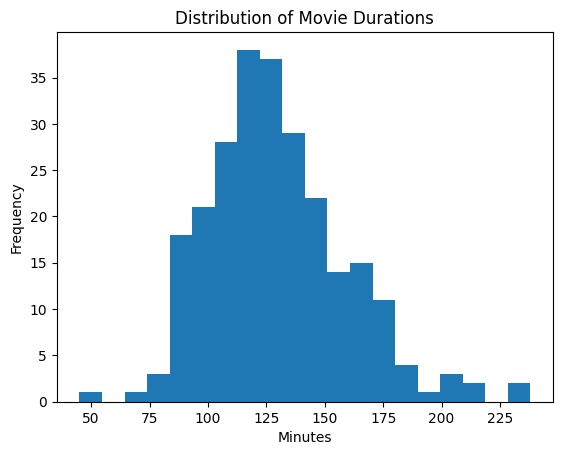

In [62]:
import matplotlib.pyplot as plt

plt.hist(df['Duration_in_minutes'], bins=20)
plt.title('Distribution of Movie Durations')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()


In [61]:
df.head()

,Unnamed: 0,Name,Genre,Description,Duration,Duration_in_minutes
0,0,The Shawshank Redemption,Drama,A banker convicted of uxoricide forms a friend...,PT2H22M,142
1,1,The Godfather,"Crime, Drama",The aging patriarch of an organized crime dyna...,PT2H55M,175
2,2,The Dark Knight,"Action, Crime, Drama",When a menace known as the Joker wreaks havoc ...,PT2H32M,152
3,3,Unkown,"Crime, Drama",The early life and career of Vito Corleone in ...,PT3H22M,202
4,4,12 Angry Men,"Crime, Drama",The jury in a New York City murder trial is fr...,PT1H36M,96
